Innledning
In this text we will look closer on polymers and their interactions.

We have made a numerical simulation that simulates how polymers behave over time. Our simulations take use of some simplifications. Firstly the monomers that make up the polymers are assumed to have integer coordinates in a two-dimensional grid. The attractive force between monomers is also assumed only exist between neighboring monomers belonging to different polymers.

We will first simulate a system where every polymer is a monomer. We begin by constructing a two-dimensional array in which we will place monomers randomly. Positions with a charged monomer will receive a unique positive index if there is a positively charged monomer at that location, and similarly a negative index if the charge is negative. Every other position will store a 0 value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import random
import time

In [3]:
# Oppgave 1a)

def create_grid(N, M):
    grid = np.zeros((N, N), dtype=int)
    indices = [(i, j) for i in range(N) for j in range(N)]
    random_monomer_indices = random.sample(indices, 2 * M)
    monomers = [m for m in range(-M, M + 1) if m != 0]
    for monomer, index in zip(monomers, random_monomer_indices):
        grid[index] = monomer
    return grid

if __name__ == '__main__':
    gr = create_grid(10, 10)
    print(gr)

[[  0   0   0   0   0   0   7  -9   0  -8]
 [ -4   0   2  -5  -3   0   0   0   9   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   3   5   0   0   8   0   0  -1   0]
 [  0   0 -10   0   0   0   0   0   0   0]
 [  0  -7   0   0   0   0   0   0   0   0]
 [  0   0  -2   0   0   0   6   0   0   0]
 [  0   0   0   4   0  -6   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  10   0   0   0]]


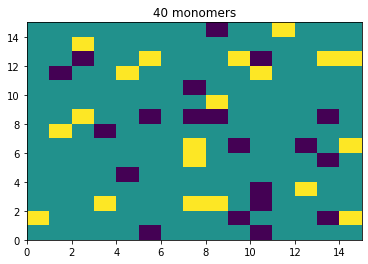

In [3]:
# Oppgave 1b)

def show_monomers(grid, M):
    """
    Input is the grid (grid) as well as the number of monomers (M).
    """
    plt.figure(1)
    plt.pcolormesh(np.sign(grid)[::-1,])
    plt.title(f"{2*M} monomers")
    plt.show()

N = 15
M = 20
grid = create_grid(N, M)
show_monomers(grid, M)

An important piece of information we can collect from our system is its total energy. Because of our simplified assumptions about the system, we only need to compare neighboring monomers to find this value. For every position in our grid we want to define a function that returns its four nearest neighbors. We can then iterate through the location of all our monomers and check if it is adjacent to a different monomer. Every pair of adjacent monomers should contribute to the total energy of the system.

In [4]:
# Oppgave 1c)

@njit
def neighbor_coordinates(N, i, j):
    neighbors = (((i - 1) % N, j), (i, (j - 1) % N), ((i + 1) % N, j), (i, (j + 1) % N))
    return neighbors

In [5]:
# Oppgave 1d)

ε_r = 78  # [1] Relative permittivity
ε_0 = 8.85418782e-12  # [m^-3 kg^-1 s^4 A^2] vacuum permittivity
a = 23e-6  # [m] Distance between grid points (23 microns)
e = 1.60217662e-19  # [C]
α = e ** 2 / (4 * np.pi * ε_r * ε_0 * a ** 2)

@njit
def calc_relative_energy(grid):
    N = len(grid)
    monomer_indices = np.where(grid != 0)
    relative_energy = 0

    for monomer_index in zip(*monomer_indices):
        monomer = grid[monomer_index]
        for neighbor_coord in neighbor_coordinates(N, *monomer_index):
            neighbour_monomer = grid[neighbor_coord]
            if neighbour_monomer != monomer and neighbour_monomer != 0:  # i.e. not the same type or solvent
                relative_energy += np.sign(monomer) * np.sign(neighbour_monomer)

    return relative_energy
print(calc_relative_energy(grid))

2


In [6]:
# Oppgave 1 e)

@njit
def move_random_polymer(grid, M, is_illegal_move, move_polymer):
    random_polymer, random_direction = choose_random_legal_move(grid, M, is_illegal_move)
    return move_polymer(grid, random_polymer, random_direction)


@njit
def illegal_move(grid, monomer, direction):
    N = len(grid)
    monomer_location = np.where(grid == monomer)
    return grid[(monomer_location[0][0] + direction[0]) % N, (monomer_location[1][0] + direction[1]) % N] != 0

@njit
def move_monomer(grid, monomer, direction):
    N = len(grid)
    new_grid = np.copy(grid)
    monomer_location = np.where(grid == monomer)
    new_grid[monomer_location[0][0], monomer_location[1][0]] = 0
    new_grid[(monomer_location[0][0] + direction[0]) % N, (monomer_location[1][0] + direction[1]) % N] = monomer
    return new_grid

@njit
def do_nothing(*args): pass

@njit
def choose_random_polymer(M):
    a = np.random.randint(-M, M)
    while not a:
        a = np.random.randint(-M, M)
    return a


directions = np.array([[-1, 0], [0, -1], [1, 0], [0, 1]])
@njit
def choose_random_direction():
    i = np.random.randint(0, 4)
    return directions[i]

@njit
def choose_random_legal_move(grid, M, is_illegal_move=illegal_move):
    random_monomer = choose_random_polymer(M)
    random_direction = choose_random_direction()
    while is_illegal_move(grid, random_monomer, random_direction):
        random_monomer = choose_random_polymer(M)
        random_direction = choose_random_direction()
    return random_monomer, random_direction

@njit
def should_measure(t, t_equil, t_r):
    return (t - t_equil) > 0 and (t - t_equil) % t_r == 0

@njit
def thermal_fluctuation(new_energy, energy, beta):
    return random.uniform(0, 1) < np.exp(-beta * (new_energy - energy))

@njit
def add_neighbours_to_cluster(grid, cluster_grid, cluster, monomer_coordinate):
    N = len(grid)
    for neighbor_coordinate in neighbor_coordinates(N, *monomer_coordinate):
        if grid[neighbor_coordinate] != 0 and cluster_grid[neighbor_coordinate] == 0:
            cluster_grid[neighbor_coordinate] = cluster
            add_neighbours_to_cluster(grid, cluster_grid, cluster, neighbor_coordinate)

@njit
def get_cluster_grid(grid):
    cluster_grid = np.zeros_like(grid)
    monomer_positions = np.where(grid != 0)
    cluster = 0
    for monomer_position in zip(*monomer_positions):
        if cluster_grid[monomer_position] == 0:
            cluster += 1
            cluster_grid[monomer_position] = cluster
            add_neighbours_to_cluster(grid, cluster_grid, cluster, monomer_position)

    return cluster_grid, cluster

@njit
def monte_carlo(grid, N_s, M, T, n=0, t_equil=np.inf, t_r=np.inf,
                is_illegal_move=illegal_move, move_polymer=move_monomer, on_iteration=do_nothing):
    epsilon = np.zeros(N_s)
    beta = 1 / (T * 1.380649e-23) * α / 2

    cluster_sizes = np.zeros(n)
    measure_index = 0

    for t in range(N_s):
        rel_energy = calc_relative_energy(grid)

        new_grid = move_random_polymer(grid, M, is_illegal_move, move_polymer)
        new_rel_energy = calc_relative_energy(new_grid)

        if new_rel_energy < rel_energy or thermal_fluctuation(new_rel_energy, rel_energy, beta):
            grid = new_grid
            rel_energy = new_rel_energy

        epsilon[t] = rel_energy

        if should_measure(t, t_equil, t_r):
            _, d = get_cluster_grid(grid)
            cluster_sizes[measure_index] = 2 * M / d
            measure_index += 1

        if t % 100 == 1:
            on_iteration(grid, epsilon[:t])

    if t_r == np.inf:
        return grid, epsilon, 0

    return grid, epsilon, np.mean(cluster_sizes[:measure_index])

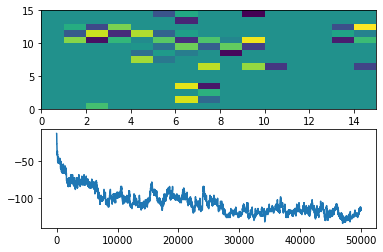

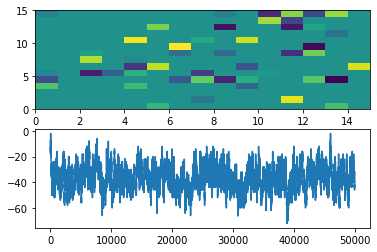

In [7]:
# Oppgave 1 f)
def create_axs():
    _, axs = plt.subplots(2)
    return axs

def plot_energy_and_grid(energy, final_grid):
    ax1, ax2 = create_axs()
    ax1.pcolormesh(final_grid[::-1, ])
    ax2.plot(energy)
    plt.show()

def simulate_monomers(N, M, N_s, T):
    grid = create_grid(N, M)
    grid, epsilon, _ = monte_carlo(grid, N_s, M, T)
    plot_energy_and_grid(epsilon, grid)

N_s = 50_000
N = 15
M = 25
T = [200, 500]

simulate_monomers(N,M,N_s, T[0])
simulate_monomers(N,M,N_s, T[1])

In [8]:
# Oppgave 1 g)

@njit
def get_cluster_grid(grid):
    cluster_grid = np.zeros_like(grid)
    monomer_positions = np.where(grid != 0)
    cluster = 0
    for monomer_position in zip(*monomer_positions):
        if cluster_grid[monomer_position] == 0:
            cluster += 1
            cluster_grid[monomer_position] = cluster
            add_neighbours_to_cluster(grid, cluster_grid, cluster, monomer_position)

    return cluster_grid, cluster

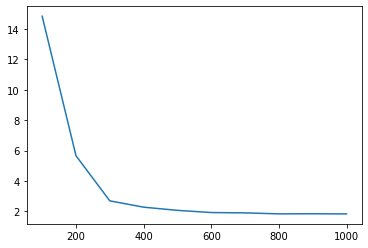

In [9]:
# Oppgave 1 h)
def plot_mean_cluster_sizes(mean_cluster_sizes, temperatures):
    plt.plot(temperatures, mean_cluster_sizes)
    plt.show()

def t_equil(T, t_max, s, T_l, C):
    return int(t_max * np.exp(-s * (T - T_l)) + C)

def sim_mean_cluster_size():
    t_max = 100_000
    s = 1 / 200
    T_l = 100
    T_h = 1_000
    temperatures = np.linspace(T_l, T_h, 10)
    t_r = 1000
    C = 10_000
    N = 15
    M = 25
    n = 100

    results = [monte_carlo(grid=create_grid(N, M),
                           N_s=t_equil(T, t_max, s, T_l, C) + t_r * n,
                           M=M, T=T, n=n,
                           t_equil=t_equil(T, t_max, s, T_l, C),
                           t_r=t_r)
               for T in temperatures]

    mean_cluster_sizes = [mean_cluster_size for _, _, mean_cluster_size in results]
    plot_mean_cluster_sizes(mean_cluster_sizes, temperatures)

sim_mean_cluster_size()

Oppgave 2

In [10]:
# Oppgave 2 a)

def random_available_position_index(grid):
    indices = np.array(np.where(grid == 0)).T
    i = np.random.randint(len(indices))
    return tuple(indices[i])


def available_neighbor_positions(grid, monomer_positions):
    N = len(grid)
    return {position for monomer in monomer_positions
            for position in neighbor_coordinates(N, *monomer)
            if grid[position] == 0}


def random_available_neighbor_position(grid, monomer_positions):
    neighbor_coords = available_neighbor_positions(grid, monomer_positions)
    return random.sample(neighbor_coords, 1)[0]


def create_polymer_grid(N, M, L):
    grid = np.zeros((N, N), dtype=int)
    polymers = [polymers for polymers in range(-M, M + 1) if polymers != 0]

    for polymer in polymers:
        rand_position = random_available_position_index(grid)
        grid[rand_position] = polymer

        monomer_positions = np.zeros((L, 2), dtype=int)
        monomer_positions[0] = rand_position

        for j in range(1, L):
            neighbor_positon = random_available_neighbor_position(grid, monomer_positions[:j])
            grid[neighbor_positon] = polymer
            monomer_positions[j] = neighbor_positon

    return grid

In [11]:
# Oppgave 2 b)

@njit
def calc_relative_energy(grid):
    N = len(grid)
    monomer_indices = np.where(grid != 0)
    relative_energy = 0

    for monomer_index in zip(*monomer_indices):
        monomer = grid[monomer_index]
        for neighbor_coord in neighbor_coordinates(N, *monomer_index):
            neighbour_monomer = grid[neighbor_coord]
            if neighbour_monomer != monomer and neighbour_monomer != 0:  # i.e. not the same type or solvent
                relative_energy += np.sign(monomer) * np.sign(neighbour_monomer)

    return relative_energy

In [12]:
# Oppgave 2 c)

@njit
def is_legal_rigid_move(grid, polymer, attempted_new_positions):
    for i, j in attempted_new_positions:
        monomer = grid[i, j]
        if monomer != 0 and monomer != polymer:
            return False
    else:
        return True

@njit
def rigid_move(grid, polymer, direction):
    N = len(grid)
    monomer_positions = np.array([[i, j] for i in range(N) for j in range(N) if grid[i, j] == polymer])

    attempted_new_positions = (monomer_positions + direction) % N

    if is_legal_rigid_move(grid, polymer, attempted_new_positions):
        new_grid = np.copy(grid)
        for i, j in monomer_positions:
            new_grid[i, j] = 0
        for i, j in attempted_new_positions:
            new_grid[i, j] = polymer
        return new_grid
    else:
        return grid

C:\Users\phili\AppData\Local\Temp\ipykernel_6640\3929427981.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(neighbor_coords, 1)[0]


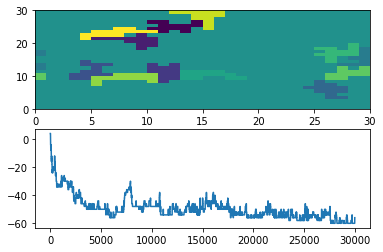

In [13]:
# Oppgave 2 d)
@njit
def allways_false(*args): return False

def simulation_with_polymers():
    N = 30
    L = 13
    M = 6
    T = 200
    N_s = 30_000
    grid = create_polymer_grid(N, M, L)
    final_grid, energy, _ = monte_carlo(grid, N_s, M, T, move_polymer=rigid_move, is_illegal_move=allways_false)
    plot_energy_and_grid(energy, final_grid)

simulation_with_polymers()

In [14]:
# Oppgave 2 e) og f)

@njit
def is_polymer_broken(grid, polymer):
    N = len(grid)
    monomer_positions = np.array([[i, j] for i in range(N) for j in range(N) if grid[i, j] == polymer])

    clean_grid = np.zeros((N, N))
    for monomer in zip(monomer_positions):
        clean_grid[monomer] = polymer
    new_grid = return_cluster(clean_grid, monomer_positions[0][0], monomer_positions[0][1], polymer)
    new_monomer_positions = np.array([[i, j] for i in range(N) for j in range(N) if new_grid[i, j] == -polymer])

    if len(monomer_positions) == len(new_monomer_positions):
        return False
    return True

@njit
def return_cluster(grid, i, j, polymer):
    N = len(grid)
    neighbours = neighbor_coordinates(N, i, j)

    for neighbour in neighbours:
        if grid[neighbour[0], neighbour[1]] == polymer:
            grid[neighbour[0], neighbour[1]] = -polymer
            grid = return_cluster(grid, neighbour[0], neighbour[1], polymer)
    return grid

@njit
def medium_flexibility_move(grid, polymer, direction):
    N = len(grid)
    monomer_positions = np.array([[i, j] for i in range(N) for j in range(N) if grid[i, j] == polymer])
    attempted_new_positions = (monomer_positions + direction) % N
    if is_legal_rigid_move(grid, polymer, attempted_new_positions):
        return rigid_move(grid, polymer, direction)

    new_grid = np.copy(grid)
    for coordinate in monomer_positions:
        value_at_new_position = grid[(coordinate[0]+direction[0]) % N, (coordinate[1] + direction[1]) %N]

        if value_at_new_position != 0 and value_at_new_position != polymer:
            for ind, coord in enumerate(monomer_positions):
                if direction[0]:
                    if coord[1] == coordinate[1]:
                        attempted_new_positions[ind] -= direction
                else:
                    if coord[0] == coordinate[0]:
                        attempted_new_positions[ind] -= direction
    for i, j in monomer_positions:
        new_grid[i, j] = 0
    for i, j in attempted_new_positions:
        new_grid[i, j] = polymer
    check_grid = np.copy(new_grid)
    if is_polymer_broken(check_grid, polymer):
        return grid
    return new_grid

In [ ]:
# Oppgave 2 g)

def simulation_with_polymers_using_medium_flexibility():
    N = 30
    L = 13
    M = 6
    T = 200
    N_s = 2000
    grid = create_polymer_grid(N, M, L)
    t0=time.perf_counter()
    final_grid, energy, _ = monte_carlo(grid, N_s, M, T,
                                        move_polymer=medium_flexibility_move,
                                        is_illegal_move=allways_false)
    plot_energy_and_grid(energy, final_grid)
    t1 = time.perf_counter()
    print(f"Tid brukt: {t1-t0} på {N_s} iterasjoner")

simulation_with_polymers_using_medium_flexibility()

C:\Users\phili\AppData\Local\Temp\ipykernel_6640\3929427981.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(neighbor_coords, 1)[0]


In [ ]:
# Oppgave 2 h)

def plot_mean_cluster_sizes_per_L(mean_cluster_sizes_per_L, L):
    plt.plot(L, mean_cluster_sizes_per_L)
    plt.show()

def calculate_expected_values():
    T = 300
    t_r = 1000
    N = 30
    M = 5
    N_s = 30_000
    mean_cluster_sizes_per_L = np.zeros(13)
    L = [i for i in range(3, 42, 3)]

    for i in range(13):
        grid = create_polymer_grid(N, M, L[i])
        final_grid, energy, _ = monte_carlo(grid, N_s, M, T, move_polymer=medium_flexibility_move, is_illegal_move=allways_false)
        mean_cluster_sizes_per_L[i] = _ / L[i]
    plot_mean_cluster_sizes_per_L(mean_cluster_sizes_per_L, L)

calculate_expected_values()